# Artificial Benchmark for Community Detection with Outliers (ABCD+o)

This notebook contains the code to run the experiments and generated the plots for the above paper.

Some intermediate results are saved as "pickle" files to speed-up the process.

For a full re-running of all experiments, the following tools need to be installed:

* The node2vec graph embedding code from: https://github.com/snap-stanford/snap/tree/master/examples/node2vec
* The graph embedding divergence code from: https://github.com/ftheberge/Comparing_Graph_Embeddings

and the full paths to the executable lies needs to be supplied, as below:

In [1]:
## Adjust as required:

## location of the node2vec code
n2v = './Code/node2vec'

## location of the GED code
GED = './Code/GED'


## Non-deterministic experiments

Several experiments belo rely on running non-determinjstic algorithms such as *node2vec* embedding or *ECG* clustering; therefore, results may not be identical each time, but should be very similar.


## Datasets

The *Data* directory contains the following files:
* several *pickle* files (*.pkl) with intermediuate results
* the Football dataset
* The ABCD+o datasets
* The Email-EU dataset


In [2]:
## the data directory
datadir = './Data/'


In [3]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import os
import partition_igraph
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import roc_auc_score as AUC
import subprocess
import pickle


## Function calling the GED executable

* This is required to compute Jenssen-Shannon divergence fpr graph embeddings

In [4]:
## Computing JS divergence with GED code given edgelist, communities and embedding
def JS(edge_file, comm_file, embed_file, entropy=False):
    if entropy:
        x = GED+' -E -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    else:
        x = GED+' -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    s = subprocess.run(x, shell=True, stdout=subprocess.PIPE)
    x = s.stdout.decode().split(' ')
    div = float(x[1])
    return(div)


# The US Football Graph

This is a nice, small graph for illustrating anomaly detection methods.
The graph consists of 115 US college football teams (nodes) playing games (edges).

Teams are part of 12 conferences (the 'communities'):
*   0 = Atlantic Coast
*   1 = Big East
*   2 = Big Ten
*   3 = Big Twelve
*   4 = Conference USA
*   5 = Independents
*   6 = Mid-American
*   7 = Mountain West
*   8 = Pacific Ten
*   9 = Southeastern
*  10 = Sun Belt
*  11 = Western Athletic

14 teams out of 115 appear as "anomalies" as can be seen in Figure 5 of [REF], namely:
- 5 teams in #5 conference (Independent) play teams in other conferences (green triangles in plot below)
- 7 teams in #10 conference (Sun Belt) are broken in 2 clumps (pink triangles in plot below) 
- 2 teams from #11 conference play mainly with #10 conference (red triangles below)

[Reference]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman
PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799



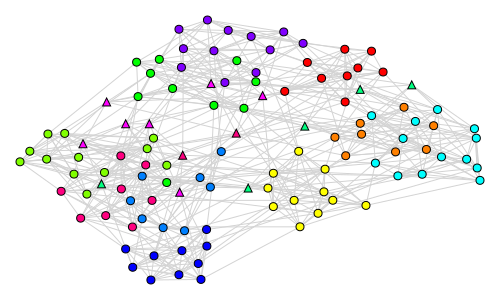

In [5]:
## read the graph and ground-truth communities
cfg = ig.Graph.Read_Ncol(datadir+'Football/football.edgelist',directed=False)
c = np.loadtxt(datadir+'Football/football.community',dtype='uint16',usecols=(0))
cfg.vs['community'] = [c[int(x['name'])] for x in cfg.vs]

## plot the College Football Graph (Figure 3)
## show communities in dfferent colors
## show known anomalies as triangles
cfg.vs['shape'] = 'circle'
cfg.vs['anomaly'] = 0
pal = ig.RainbowPalette(n=max(cfg.vs['community'])+1) 
cfg.vs['color'] = [pal.get(int(i)) for i in cfg.vs['community']]
for v in cfg.vs:
    if v['community'] in [5,10] or v['name'] in ['28','58']:
        v['shape']='triangle'
        v['anomaly']=1
ly = cfg.layout_fruchterman_reingold()
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')
#ig.plot(cfg, target="football_color.eps", layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')


# Looking for anomalies - 4 different methods illustrated

Figures 4, 5, 6 and 8

## (1) Entropy-based method

Here, we try to recover those anomalous teams by running several node2vec embeddings with different parameters.
For each embedding:
* compute JS-divergence using the framework
* compute the entropy of the b-vector for each node (i.e. the probability distribution of edges w.r.t. every community in the geometric Chung-Lu model)
* since we have the ground truth (anomalous nodes), we also compute the area under the ROC curve (AUC)

From those results:
* plot entropy vs divergence
* for some good (or bad) embedding, we show boxplot for the entropy of anomalous vs other nodes

There are several other methods to find anomalous nodes, but this simple approach yields good results. The rationale is that an "anomalous" node will be difficult to place in a cluster, so the geometric Chung-Lu model will predict edges to several different clusters.


## Note

Running the following cell requires installation of *node2vec* and *GED* executables as detailed earlier.
For convenience, it is commented out and a *pkl* file is provided with pre-run results and can be loaded (2nd cell below).

Note that results from *node2vec* are non-deterministic, so results from different runs will be similar, but not identical.


In [6]:
## load pre-run experiment results

with open(datadir+'entropy_football.pkl', 'rb') as fp:
    D, best_ent = pickle.load(fp) 
print(D.head())    

    dim algo  param       jsd       auc
48   20  n2v  0.1 1  0.007244  0.973833
33   14  n2v  0.1 1  0.007657  0.873409
53   22  n2v  0.1 1  0.008496  0.907355
18    8  n2v  0.1 1  0.008519  0.946959
58   24  n2v  0.1 1  0.009658  0.980198


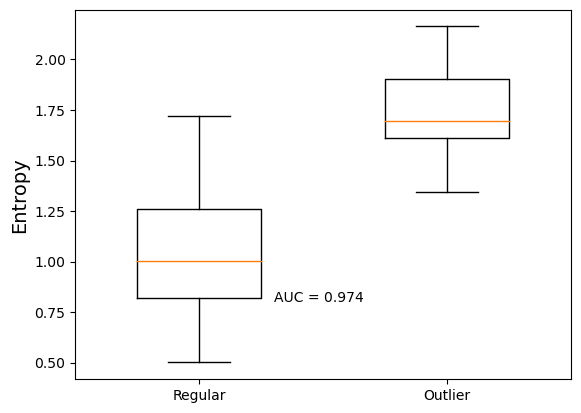

In [7]:
## plot the results w/ a good embedding
cfg.vs['ent'] = best_ent
X = [v['ent'] for v in cfg.vs if v['anomaly']==0]
Y = [v['ent'] for v in cfg.vs if v['anomaly']==1]
plt.boxplot([X,Y],labels=['Regular','Outlier'],sym='.',whis=(0,100), widths=.5)
plt.ylabel('Entropy',fontsize=14)

s = 'AUC = ' + "%.3f"%AUC(cfg.vs['anomaly'],cfg.vs['ent'])
plt.text(1.3,0.8,s);
#plt.savefig('entropy.pdf')

## (2) Participation coefficients

Here we consider the ground truth communities and compute the participation coefficient (PC) for each node; participation coefficient is lower if neighbours are mostly from the same community.

Thus we expect higher PC for outlier nodes.


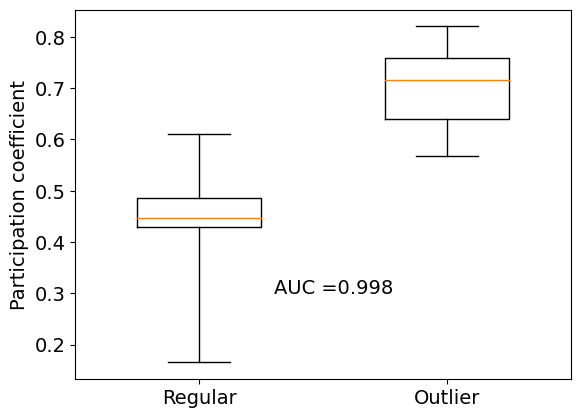

In [8]:
## run ECG - we use it here and in next test
ec = cfg.community_ecg(ens_size=32)
cfg.es['W'] = ec.W
cfg.vs['ecg'] = ec.membership

## participation coef
for v in cfg.vs:
    l = list(Counter([cfg.vs[x]['ecg'] for x in cfg.neighbors(v)]).values())
    s = sum(l)
    v['pc'] = 1-sum([i**2/s**2 for i in l])
    
X = [v['pc'] for v in cfg.vs if v['anomaly']==0]
Y = [v['pc'] for v in cfg.vs if v['anomaly']==1]
plt.rcParams['font.size'] = '14'
plt.boxplot([X,Y],labels=['Regular','Outlier'],sym='.',whis=(0,100), widths=.5)
plt.ylabel('Participation coefficient',fontsize=14)
s = 'AUC =' + "%.3f"%AUC(cfg.vs['anomaly'],cfg.vs['pc'])
plt.text(1.3,0.3,s);
#plt.savefig('participation.pdf');

## (3) ECG - distribution of "votes"

ECG is a concensus clustering method based on the Louvain algorithm.
In its first phase, several low-level partitions are computes with different randomization, 
and for each edge, we compute the proportion of times both nodes ended up in the same part.
Those are the ECG (edge) scores. High scores are indicative of stable partitions.

We expect anomalous nodes to be harder to cluster, thus with smaller average incident ECG scores.


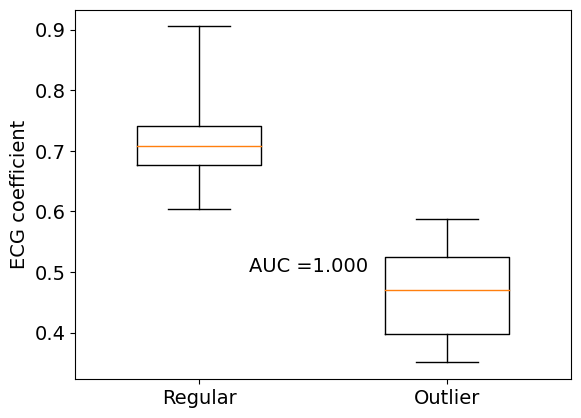

In [9]:
## ECG votes - average per node
for v in cfg.vs:
    v['W'] = np.mean([cfg.es[e]['W'] for e in cfg.incident(v)])
plt.rcParams['font.size'] = '14'

X = [v['W'] for v in cfg.vs if v['anomaly']==0]
Y = [v['W'] for v in cfg.vs if v['anomaly']==1]
plt.boxplot([X,Y],labels=['Regular','Outlier'],sym='.',whis=(0,100), widths=.5)
plt.ylabel('ECG coefficient',fontsize=14)
s = 'AUC =' + "%.3f"%AUC(cfg.vs['anomaly'],[1-x for x in cfg.vs['W']])
plt.text(1.2,0.5,s);
#plt.savefig('ecg.pdf');


## (4) Difference - edges within vs between communities

For each node, compute
* fraction of edges in community (i.e. fraction of neighbours in same community)
* expected value for the above, i.e. (vol(A)-deg(v)) / (vol(V)-deg(v)) where A is v's community
* take the difference


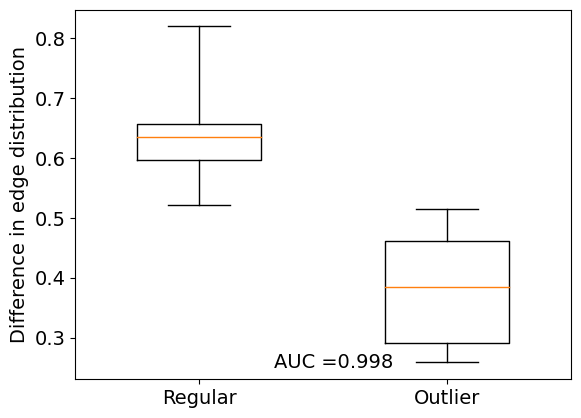

In [10]:
## compute differences
volV = np.sum(cfg.degree())
volA = np.zeros(max(cfg.vs['ecg'])+1, dtype='int')
for v in cfg.vs:
    volA[v['ecg']] += v.degree()

for v in cfg.vs:
    nei = [cfg.vs[w]['ecg']==v['ecg'] for w in cfg.neighbors(v)]
    v['frac'] = np.sum(nei) / len(nei)
    v['exp_frac'] = (volA[v['ecg']] - v.degree()) / (volV - v.degree())
    v['diff'] = v['frac'] - v['exp_frac']

X = [v['diff'] for v in cfg.vs if v['anomaly']==0]
Y = [v['diff'] for v in cfg.vs if v['anomaly']==1]
plt.rcParams['font.size'] = '14'
plt.boxplot([X,Y],labels=['Regular','Outlier'],sym='.',whis=(0,100), widths=.5)
plt.ylabel('Difference in edge distribution',fontsize=14)
s = 'AUC =' + "%.3f"%AUC(cfg.vs['anomaly'],cfg.vs['pc'])
plt.text(1.3,0.25,s);
#plt.savefig('diff.pdf');

# Experiments with ABCD-o graphs

## plotting the small graphs (n = 100, o = 5) 

Figure 2

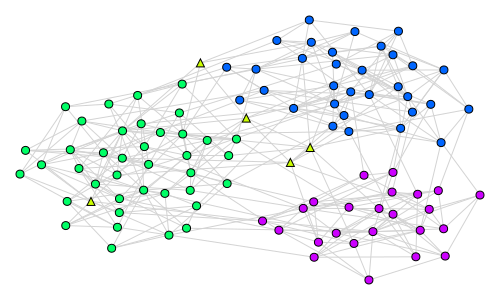

In [11]:
xi = '02' ## noise ('02' or '04')
out = '5' ## number of outliers ('0' or '5')

## read graph and communities
fn = datadir+"ABCDo/graphs_100/edge"+xi+"_"+out+".dat"
g = ig.Graph.Read_Ncol(fn,directed=False)
fn = datadir+"ABCDo/graphs_100/com"+xi+"_"+out+".dat"
c = np.loadtxt(fn,dtype='uint16',usecols=(1))
g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
## show known anomalies as triangles
g.vs['shape'] = 'circle'
g.vs['anomaly'] = 0
for v in g.vs:
    if v['community'] == 1:
        v['shape']='triangle'
        v['anomaly']=1
ly = g.layout_fruchterman_reingold()
pal = ig.RainbowPalette(n=max(g.vs['community'])+1) 
g.vs['color'] = [pal.get(int(i)) for i in g.vs['community']]
ig.plot(g, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')

## plot to file - color
#fn = "graph"+xi+"_"+out+"_color.eps"
#pal = ig.RainbowPalette(n=max(g.vs['community'])+1) 
#g.vs['color'] = [pal.get(int(i)) for i in g.vs['community']]
#ig.plot(g, target=fn, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')
## plot to file - bw
#fn = "graph"+xi+"_"+out+"_bw.eps"
#pal = ig.GradientPalette("white","black",max(g.vs['community'])+1)
#g.vs['color'] = [pal.get(int(i)) for i in g.vs['community']]
#ig.plot(g, target=fn, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')


## Participation coefficient - large graphs (n=10k, o=500)

Figure 4, second plot

This can take a few minutes to run


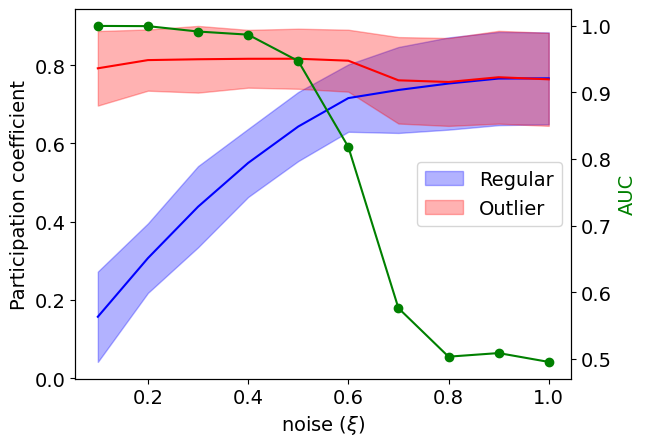

In [12]:
XI = ['01','02','03','04','05','06','07','08','09','10']
L_mean = []
L_sdv = []
O_mean = []
O_sdv = []
A = []
for xi in XI:
    ## read graph and communities
    fn = datadir+"ABCDo/graphs_10000/edge"+xi+"_500.dat"
    g = ig.Graph.Read_Ncol(fn,directed=False)
    fn = datadir+"ABCDo/graphs_10000/com"+xi+"_500.dat"
    c = np.loadtxt(fn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
    g.vs['anomaly'] = False
    for v in g.vs:
        if v['community'] == 1:
            v['anomaly']=True
    g.vs['community'] = g.community_ecg(ens_size=32).membership
    ## show known anomalies as triangles
    
    for v in g.vs:
        l = list(Counter([g.vs[x]['community'] for x in g.neighbors(v)]).values())
        s = sum(l)
        v['pc'] = 1-sum([i**2/s**2 for i in l])
    
    X = [v['pc'] for v in g.vs if v['anomaly']==0]
    Y = [v['pc'] for v in g.vs if v['anomaly']==1]

    L_mean.append(np.mean(X))
    L_sdv.append(np.std(X))
    O_mean.append(np.mean(Y))
    O_sdv.append(np.std(Y))
    A.append(AUC(g.vs['anomaly'],g.vs['pc']))


x = np.arange(.1,1.01,.1)

# create figure and axis objects with subplots()
fig, ax = plt.subplots()

# make a plot
ax.plot(x,L_mean,color='blue')
ax.fill_between(x,np.array(L_mean)-np.array(L_sdv),np.array(L_mean)+np.array(L_sdv),alpha=.3,
                 label="Regular",color='blue')
ax.plot(x,O_mean,color='red')
ax.fill_between(x,np.array(O_mean)-np.array(O_sdv),np.array(O_mean)+np.array(O_sdv),alpha=.3,
                 label="Outlier",color='red')
ax.legend(fontsize=14, loc='center right')
ax.set_xlabel(r'noise ($\xi$)',fontsize=14)
ax.set_ylabel('Participation coefficient',fontsize=14);

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x,A,color="green",marker="o")
ax2.set_ylabel("AUC",color="green",fontsize=14)
plt.show();

#fig.savefig('ABCDo_pc.pdf');


## ECG distribution of votes - large graphs (n=10k, o=500)

This can take a few minutes to run

Figure 5 (second plot)


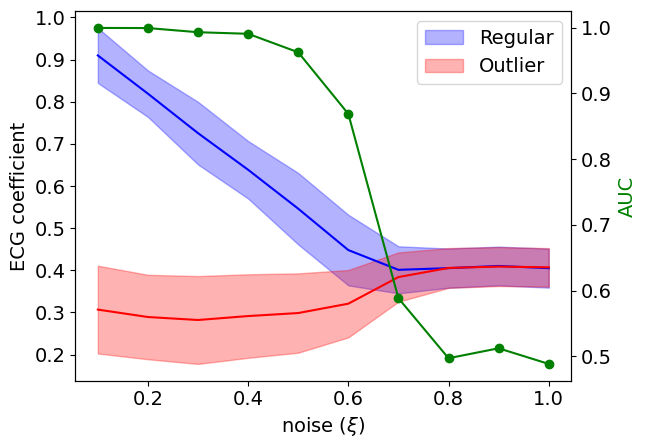

In [13]:
L_mean = []
L_sdv = []
O_mean = []
O_sdv = []
A = []
for xi in XI:
    ## read graph and communities
    fn = datadir+"ABCDo/graphs_10000/edge"+xi+"_500.dat"
    g = ig.Graph.Read_Ncol(fn,directed=False)
    fn = datadir+"ABCDo/graphs_10000/com"+xi+"_500.dat"
    c = np.loadtxt(fn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
    ## show known anomalies as triangles
    g.vs['anomaly'] = False
    for v in g.vs:
        if v['community'] == 1:
            v['anomaly']=True

    ec = g.community_ecg(ens_size=32)
    g.es['W'] = ec.W
    for v in g.vs:
        v['W'] = np.mean([g.es[e]['W'] for e in g.incident(v)])

    X = [v['W'] for v in g.vs if v['anomaly']==0]
    Y = [v['W'] for v in g.vs if v['anomaly']==1]

    L_mean.append(np.mean(X))
    L_sdv.append(np.std(X))
    O_mean.append(np.mean(Y))
    O_sdv.append(np.std(Y))

    A.append(AUC(g.vs['anomaly'],[1-x for x in g.vs['W']]))


x = np.arange(.1,1.01,.1)

# create figure and axis objects with subplots()
fig, ax = plt.subplots()

# make a plot
ax.plot(x,L_mean,color='blue')
ax.fill_between(x,np.array(L_mean)-np.array(L_sdv),np.array(L_mean)+np.array(L_sdv),alpha=.3,
                 label="Regular",color='blue')
ax.plot(x,O_mean,color='red')
ax.fill_between(x,np.array(O_mean)-np.array(O_sdv),np.array(O_mean)+np.array(O_sdv),alpha=.3,
                 label="Outlier",color='red')
ax.legend(fontsize=14)
ax.set_xlabel(r'noise ($\xi$)',fontsize=14)
ax.set_ylabel('ECG coefficient',fontsize=14);

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x,A,color="green",marker="o")
ax2.set_ylabel("AUC",color="green",fontsize=14)
plt.show();

#fig.savefig('ABCDo_ecg.pdf');


## Difference in edge distribution - large graphs (n=10k, o=500)

This can take a few minutes to run

Figure 6 (second plot)


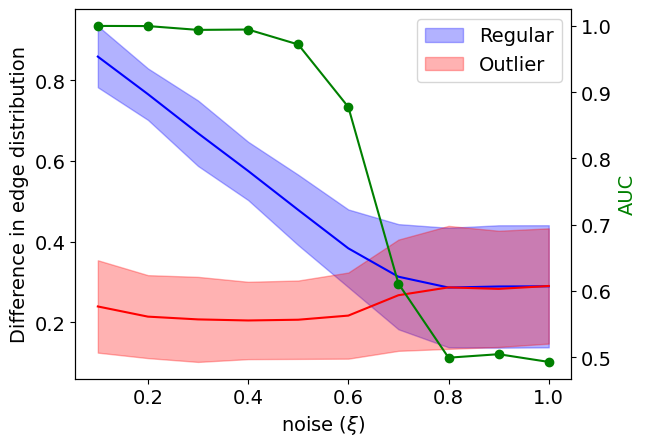

In [14]:
L_mean = []
L_sdv = []
O_mean = []
O_sdv = []
A = []
for xi in XI:
    ## read graph and communities
    fn = datadir+"ABCDo/graphs_10000/edge"+xi+"_500.dat"
    g = ig.Graph.Read_Ncol(fn,directed=False)
    fn = datadir+"ABCDo/graphs_10000/com"+xi+"_500.dat"
    c = np.loadtxt(fn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
    g.vs['anomaly'] = False
    for v in g.vs:
        if v['community'] == 1:
            v['anomaly']=True
    g.vs['ecg'] = g.community_ecg(ens_size=32).membership

    ## compute differences
    volV = np.sum(g.degree())
    volA = np.zeros(max(g.vs['ecg'])+1, dtype='int')
    for v in g.vs:
        volA[v['ecg']] += v.degree()

    for v in g.vs:
        nei = [g.vs[w]['ecg']==v['ecg'] for w in g.neighbors(v)]
        v['frac'] = np.sum(nei) / len(nei)
        v['exp_frac'] = (volA[v['ecg']] - v.degree()) / (volV - v.degree())
        v['diff'] = v['frac'] - v['exp_frac']
    

    X = [v['diff'] for v in g.vs if v['anomaly']==0]
    Y = [v['diff'] for v in g.vs if v['anomaly']==1]

    L_mean.append(np.mean(X))
    L_sdv.append(np.std(X))
    O_mean.append(np.mean(Y))
    O_sdv.append(np.std(Y))
    A.append(AUC(g.vs['anomaly'],[1-x for x in g.vs['diff']]))

x = np.arange(.1,1.01,.1)

# create figure and axis objects with subplots()
fig, ax = plt.subplots()

# make a plot
ax.plot(x,L_mean,color='blue')
ax.fill_between(x,np.array(L_mean)-np.array(L_sdv),np.array(L_mean)+np.array(L_sdv),alpha=.3,
                 label="Regular",color='blue')
ax.plot(x,O_mean,color='red')
ax.fill_between(x,np.array(O_mean)-np.array(O_sdv),np.array(O_mean)+np.array(O_sdv),alpha=.3,
                 label="Outlier",color='red')
ax.legend(fontsize=14, loc='upper right')
ax.set_xlabel(r'noise ($\xi$)',fontsize=14)
ax.set_ylabel('Difference in edge distribution',fontsize=14);

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x,A,color="green",marker="o")
ax2.set_ylabel("AUC",color="green",fontsize=14)
plt.show();

#fig.savefig('ABCDo_diff.pdf');


## Entropy-based method - large graphs (n=10k, o=500)

Figure 8, second plot

The code below is commented out,m as it is quite slow and requires installing the *node2vec* and *GED* executables, as described earlier.

Results from running this experiment can be loaded directly in the following cell.


In [15]:
## load experimental results
with open(datadir+'entropy_10000_variables.pkl', 'rb') as fp:
    L_mean,L_sdv,O_mean,O_sdv,A = pickle.load(fp)

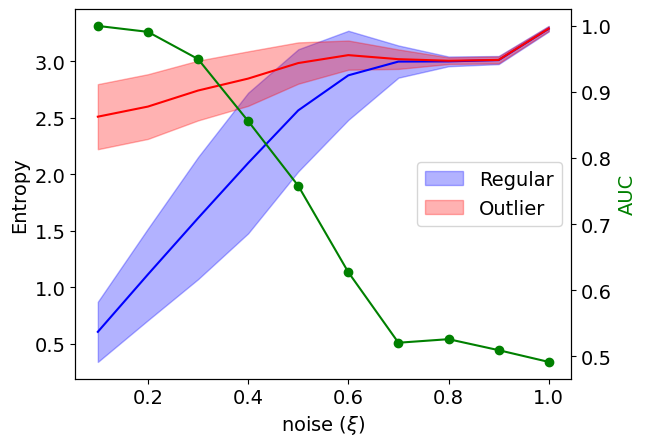

In [16]:
## plot results
x = np.arange(.1,1.01,.1)

# create figure and axis objects with subplots()
fig, ax = plt.subplots()

# make a plot
ax.plot(x,L_mean,color='blue')
ax.fill_between(x,np.array(L_mean)-np.array(L_sdv),np.array(L_mean)+np.array(L_sdv),alpha=.3,
                 label="Regular",color='blue')
ax.plot(x,O_mean,color='red')
ax.fill_between(x,np.array(O_mean)-np.array(O_sdv),np.array(O_mean)+np.array(O_sdv),alpha=.3,
                 label="Outlier",color='red')
ax.legend(fontsize=14, loc='center right')
ax.set_xlabel(r'noise ($\xi$)',fontsize=14)
ax.set_ylabel('Entropy',fontsize=14);

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x,A,color="green",marker="o")
ax2.set_ylabel("AUC",color="green",fontsize=14)
plt.show();

#fig.savefig('ABCDo_10000_entropy.pdf');


## Binning by degree

Figure 7

For 3 methods: differences, participation coefficient, ECG votes, we consider nodes of 3 types:
* low degree (<=7)
* medium-size degree (8 to 20 incl.)
* high degree (> 20)


In [17]:
# The bounds
lo = 7 
med = 20

### Binning by degree - Differences

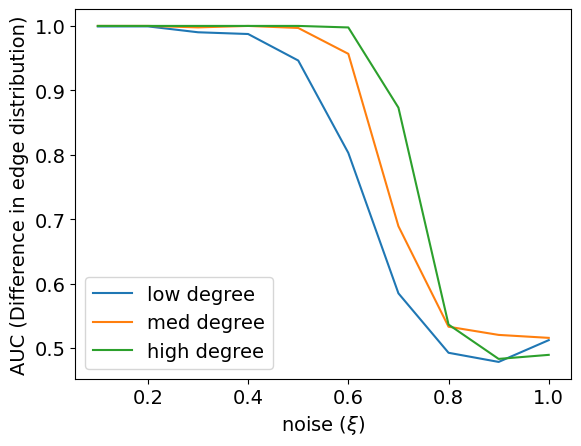

In [18]:
A1 = []
A2 = []
A3 = []

for xi in XI:
    ## read graph and communities
    fn = datadir+"ABCDo/graphs_10000/edge"+xi+"_500.dat"
    g = ig.Graph.Read_Ncol(fn,directed=False)
    fn = datadir+"ABCDo/graphs_10000/com"+xi+"_500.dat"
    c = np.loadtxt(fn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
    g.vs['anomaly'] = False
    for v in g.vs:
        if v['community'] == 1:
            v['anomaly']=True
    g.vs['ecg'] = g.community_ecg(ens_size=32).membership

    ## compute differences
    volV = np.sum(g.degree())
    volA = np.zeros(max(g.vs['ecg'])+1, dtype='int')
    for v in g.vs:
        volA[v['ecg']] += v.degree()

    for v in g.vs:
        nei = [g.vs[w]['ecg']==v['ecg'] for w in g.neighbors(v)]
        v['frac'] = np.sum(nei) / len(nei)
        v['exp_frac'] = (volA[v['ecg']] - v.degree()) / (volV - v.degree())
        v['diff'] = v['frac'] - v['exp_frac']
    
    X = [v['anomaly'] for v in g.vs if g.degree(v)<=lo]
    Y = [1-v['diff'] for v in g.vs if g.degree(v)<=lo]
    A1.append(AUC(X,Y))    
    X = [v['anomaly'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med]
    Y = [1-v['diff'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med]
    A2.append(AUC(X,Y))    
    X = [v['anomaly'] for v in g.vs if g.degree(v)>med]
    Y = [1-v['diff'] for v in g.vs if g.degree(v)>med]
    A3.append(AUC(X,Y))

x = np.arange(.1,1.01,.1)
plt.plot(x,A1,label='low degree')
plt.plot(x,A2,label='med degree')
plt.plot(x,A3,label='high degree')
plt.legend()
plt.xlabel(r'noise ($\xi$)',fontsize=14)
plt.ylabel('AUC (Difference in edge distribution)',fontsize=14);

#plt.savefig('ABCDo_diff_degrees.pdf');   

### Binning by degree - Participation coefficients

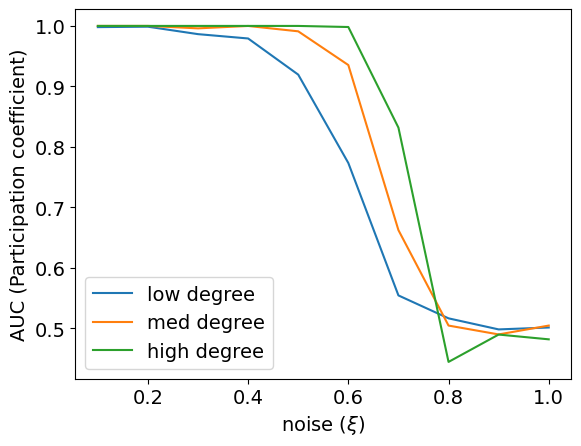

In [19]:
A1 = []
A2 = []
A3 = []

for xi in XI:
    ## read graph and communities
    fn = datadir+"ABCDo/graphs_10000/edge"+xi+"_500.dat"
    g = ig.Graph.Read_Ncol(fn,directed=False)
    fn = datadir+"ABCDo/graphs_10000/com"+xi+"_500.dat"
    c = np.loadtxt(fn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
    g.vs['anomaly'] = False
    for v in g.vs:
        if v['community'] == 1:
            v['anomaly']=True
    g.vs['ecg'] = g.community_ecg(ens_size=32).membership

    for v in g.vs:
        l = list(Counter([g.vs[x]['ecg'] for x in g.neighbors(v)]).values())
        s = sum(l)
        v['pc'] = 1-sum([i**2/s**2 for i in l])
    
    X = [v['anomaly'] for v in g.vs if g.degree(v)<=7]
    Y = [v['pc'] for v in g.vs if g.degree(v)<=7]
    A1.append(AUC(X,Y))

    X = [v['anomaly'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med]
    Y = [v['pc'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med]
    A2.append(AUC(X,Y))

    X = [v['anomaly'] for v in g.vs if g.degree(v)>med]
    Y = [v['pc'] for v in g.vs if g.degree(v)>med]
    A3.append(AUC(X,Y))

x = np.arange(.1,1.01,.1)
plt.plot(x,A1,label='low degree')
plt.plot(x,A2,label='med degree')
plt.plot(x,A3,label='high degree')
plt.legend()
plt.xlabel(r'noise ($\xi$)',fontsize=14)
plt.ylabel('AUC (Participation coefficient)',fontsize=14);
#plt.savefig('ABCDo_participation_degrees.pdf');   

### Binning by degree - ECG weights

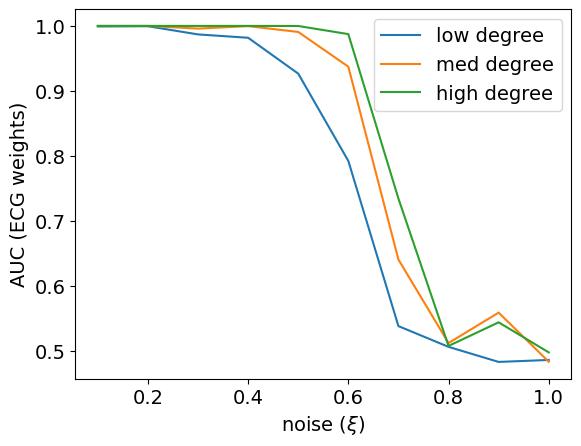

In [20]:
A1 = []
A2 = []
A3 = []

for xi in XI:
    ## read graph and communities
    fn = datadir+"ABCDo/graphs_10000/edge"+xi+"_500.dat"
    g = ig.Graph.Read_Ncol(fn,directed=False)
    fn = datadir+"ABCDo/graphs_10000/com"+xi+"_500.dat"
    c = np.loadtxt(fn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
    g.vs['anomaly'] = False
    for v in g.vs:
        if v['community'] == 1:
            v['anomaly']=True

    ec = g.community_ecg(ens_size=32)
    g.es['W'] = ec.W
    for v in g.vs:
        v['W'] = np.mean([g.es[e]['W'] for e in g.incident(v)])
        
    X = [v['anomaly'] for v in g.vs if g.degree(v)<=7]
    Y = [1-v['W'] for v in g.vs if g.degree(v)<=7]
    A1.append(AUC(X,Y))

    X = [v['anomaly'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med]
    Y = [1-v['W'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med]
    A2.append(AUC(X,Y))

    X = [v['anomaly'] for v in g.vs if g.degree(v)>med]
    Y = [1-v['W'] for v in g.vs if g.degree(v)>med]
    A3.append(AUC(X,Y))

x = np.arange(.1,1.01,.1)
plt.plot(x,A1,label='low degree')
plt.plot(x,A2,label='med degree')
plt.plot(x,A3,label='high degree')
plt.legend()
plt.xlabel(r'noise ($\xi$)',fontsize=14)
plt.ylabel('AUC (ECG weights)',fontsize=14);
#plt.savefig('ABCDo_ecg_degrees.pdf');   

# Computing some node features - ABCD+o graphs

Given different values for xi, the degree (low, med, high), and the status (outlier or not), we compute the following feature distributions:

   * closeness centrality
   * betweeness
   * eigen-centrality
   * pagerank

Figures 9-12


## (i) closeness centrality

In [21]:
##compute
A1 = []
A2 = []
A3 = []
for xi in XI:
    ## read graph and communities
    fn = datadir+"ABCDo/graphs_10000/edge"+xi+"_500.dat"
    g = ig.Graph.Read_Ncol(fn,directed=False)
    fn = datadir+"ABCDo/graphs_10000/com"+xi+"_500.dat"
    c = np.loadtxt(fn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
    g.vs['anomaly'] = False
    for v in g.vs:
        if v['community'] == 1:
            v['anomaly']=True
    ## add feature here
    g.vs['cc'] = g.closeness()
    A1.append([v['cc'] for v in g.vs if g.degree(v)<=lo and v['anomaly']==True])
    A1.append([v['cc'] for v in g.vs if g.degree(v)<=lo and v['anomaly']==False])
    A2.append([v['cc'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med and v['anomaly']==True])
    A2.append([v['cc'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med and v['anomaly']==False])
    A3.append([v['cc'] for v in g.vs if g.degree(v)>med and v['anomaly']==True])
    A3.append([v['cc'] for v in g.vs if g.degree(v)>med and v['anomaly']==False])


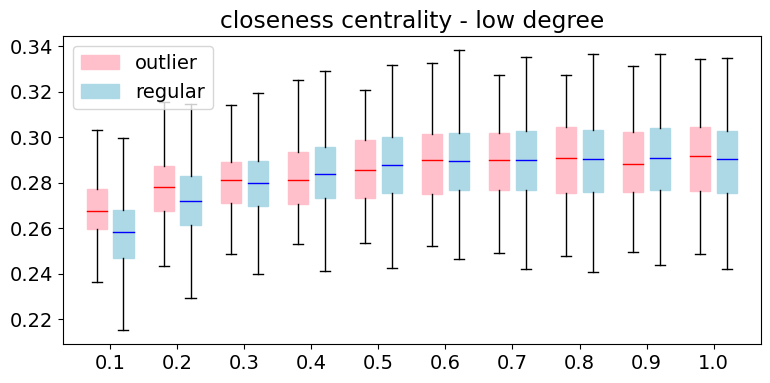

In [22]:
## plot - low degree
fig, ax = plt.subplots(figsize=(9, 4))
for i in np.arange(0,20,2):
    bp = ax.boxplot(A1[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper left')
plt.title('closeness centrality - low degree');
#plt.xlabel(r'noise ($\xi$)',fontsize=14)
#fig.savefig('close_low.pdf');   

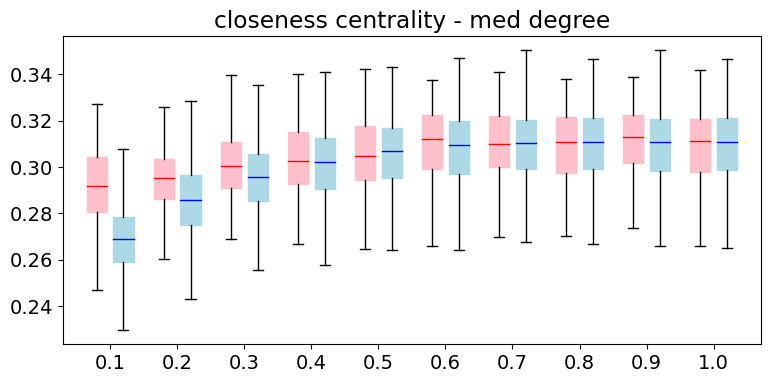

In [23]:
## plot - med degree
fig, ax = plt.subplots(figsize=(9, 4))
for i in np.arange(0,20,2):
    bp = ax.boxplot(A2[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
#ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('closeness centrality - med degree');
#plt.xlabel(r'noise ($\xi$)',fontsize=14)
#fig.savefig('close_med.pdf');   

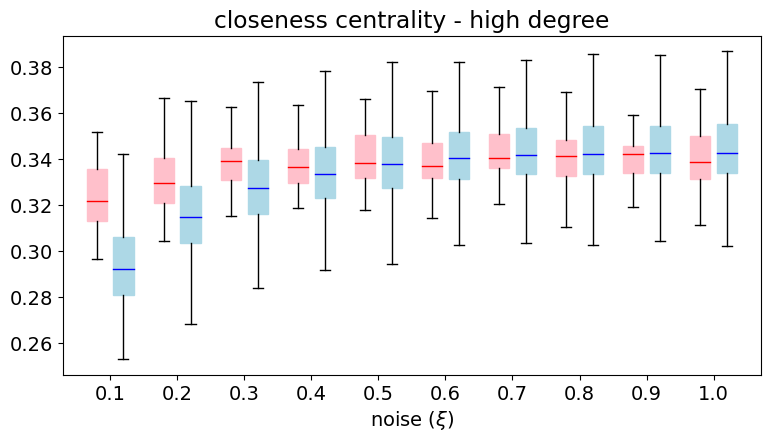

In [24]:
## plot - hi degree
fig, ax = plt.subplots(figsize=(9, 4.4))
for i in np.arange(0,20,2):
    bp = ax.boxplot(A3[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
#ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('closeness centrality - high degree');
plt.xlabel(r'noise ($\xi$)',fontsize=14);
#fig.savefig('close_hi.pdf');   

## (ii) Betweenness

In [25]:
A1 = []
A2 = []
A3 = []

for xi in XI:
    ## read graph and communities
    fn = datadir+"ABCDo/graphs_10000/edge"+xi+"_500.dat"
    g = ig.Graph.Read_Ncol(fn,directed=False)
    fn = datadir+"ABCDo/graphs_10000/com"+xi+"_500.dat"
    c = np.loadtxt(fn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
    g.vs['anomaly'] = False
    for v in g.vs:
        if v['community'] == 1:
            v['anomaly']=True

    ## add feature here
    n = g.vcount()
    den = (n-1)*(n-2)/2
    g.vs['cc'] = [i/den for i in g.betweenness()]
    

    A1.append([v['cc'] for v in g.vs if g.degree(v)<=lo and v['anomaly']==True])
    A1.append([v['cc'] for v in g.vs if g.degree(v)<=lo and v['anomaly']==False])
    A2.append([v['cc'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med and v['anomaly']==True])
    A2.append([v['cc'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med and v['anomaly']==False])
    A3.append([v['cc'] for v in g.vs if g.degree(v)>med and v['anomaly']==True])
    A3.append([v['cc'] for v in g.vs if g.degree(v)>med and v['anomaly']==False])


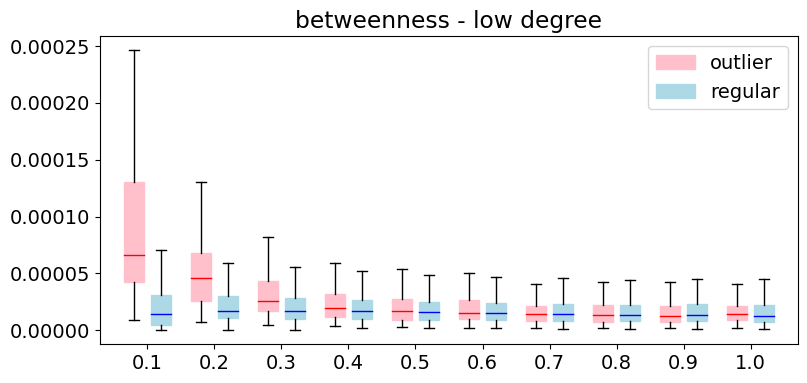

In [26]:
## plot - low degree
fig, ax = plt.subplots(figsize=(9, 4))

for i in np.arange(0,20,2):
    bp = ax.boxplot(A1[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('betweenness - low degree');
#plt.xlabel(r'noise ($\xi$)',fontsize=14)
#fig.savefig('bet_low.pdf');   

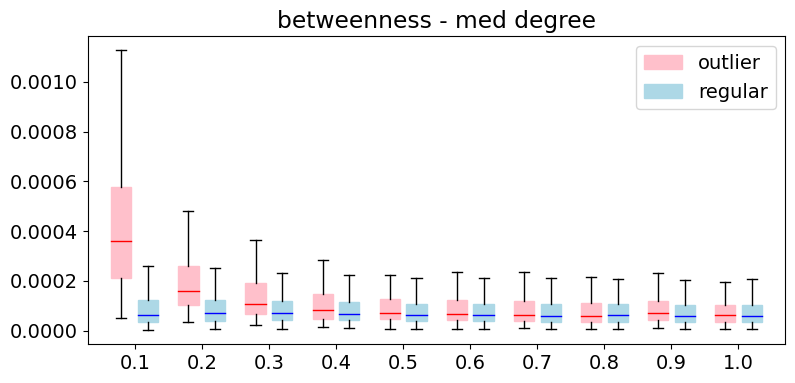

In [27]:
## plot - med degree
fig, ax = plt.subplots(figsize=(9, 4))
for i in np.arange(0,20,2):
    bp = ax.boxplot(A2[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('betweenness - med degree');
#plt.xlabel(r'noise ($\xi$)',fontsize=14)
#fig.savefig('bet_med.pdf');   

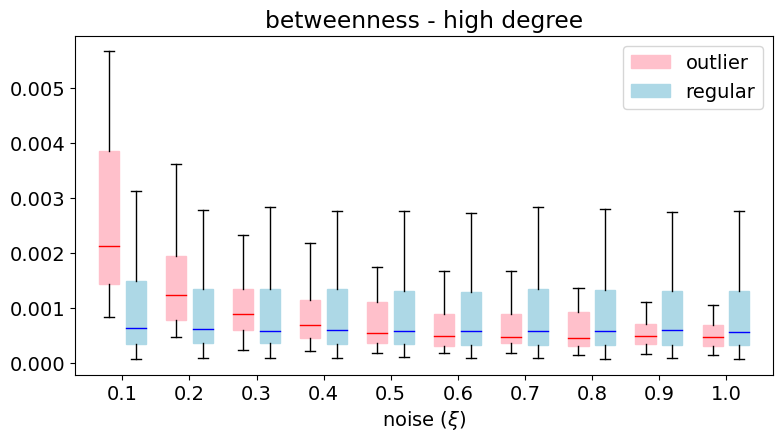

In [28]:
## plot - hi degree
fig, ax = plt.subplots(figsize=(9, 4.4))
for i in np.arange(0,20,2):
    bp = ax.boxplot(A3[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('betweenness - high degree');
plt.xlabel(r'noise ($\xi$)',fontsize=14);
#fig.savefig('bet_hi.pdf');   

## (iii) Eigen-centrality

In [29]:
A1 = []
A2 = []
A3 = []

for xi in XI:
    ## read graph and communities
    fn = datadir+"ABCDo/graphs_10000/edge"+xi+"_500.dat"
    g = ig.Graph.Read_Ncol(fn,directed=False)
    fn = datadir+"ABCDo/graphs_10000/com"+xi+"_500.dat"
    c = np.loadtxt(fn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
    g.vs['anomaly'] = False
    for v in g.vs:
        if v['community'] == 1:
            v['anomaly']=True

    ## add feature here
    g.vs['cc'] = g.eigenvector_centrality()

    A1.append([v['cc'] for v in g.vs if g.degree(v)<=lo and v['anomaly']==True])
    A1.append([v['cc'] for v in g.vs if g.degree(v)<=lo and v['anomaly']==False])
    A2.append([v['cc'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med and v['anomaly']==True])
    A2.append([v['cc'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med and v['anomaly']==False])
    A3.append([v['cc'] for v in g.vs if g.degree(v)>med and v['anomaly']==True])
    A3.append([v['cc'] for v in g.vs if g.degree(v)>med and v['anomaly']==False])


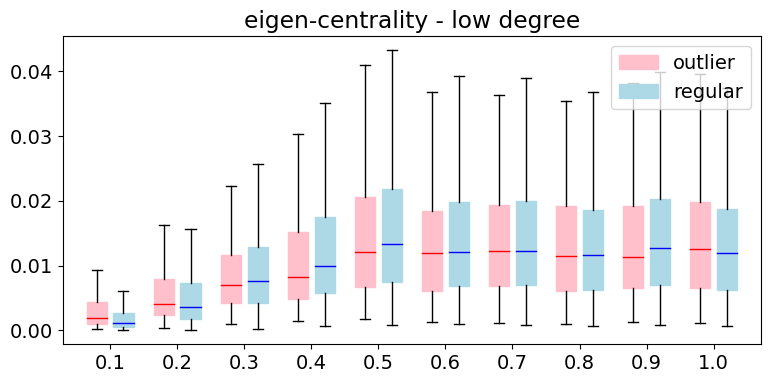

In [30]:
## plot - low degree
fig, ax = plt.subplots(figsize=(9, 4))

for i in np.arange(0,20,2):
    bp = ax.boxplot(A1[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('eigen-centrality - low degree');
#plt.xlabel(r'noise ($\xi$)',fontsize=14)
#fig.savefig('eigen_low.pdf');   

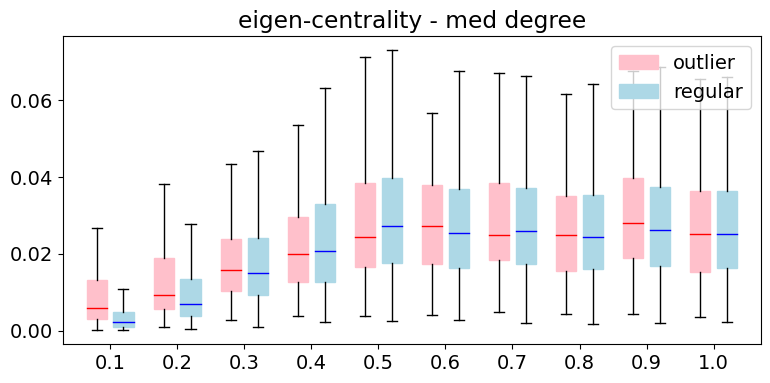

In [31]:
## plot - med degree
fig, ax = plt.subplots(figsize=(9, 4))
for i in np.arange(0,20,2):
    bp = ax.boxplot(A2[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('eigen-centrality - med degree');
#plt.xlabel(r'noise ($\xi$)',fontsize=14)
#fig.savefig('eigen_med.pdf');   

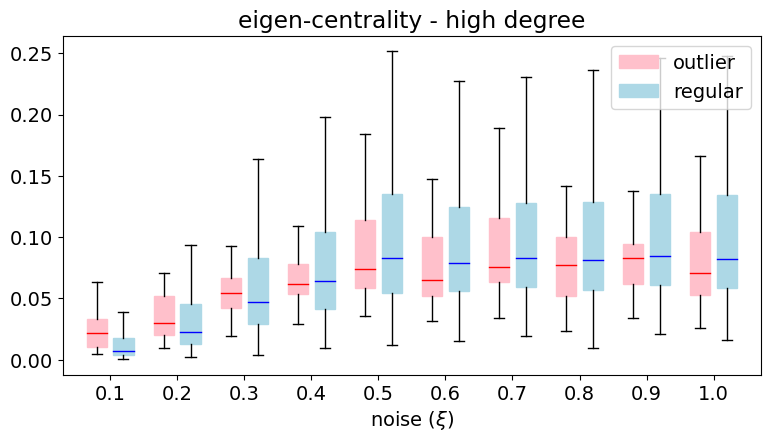

In [32]:
## plot - hi degree
fig, ax = plt.subplots(figsize=(9, 4.4))
for i in np.arange(0,20,2):
    bp = ax.boxplot(A3[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('eigen-centrality - high degree');
plt.xlabel(r'noise ($\xi$)',fontsize=14);
#fig.savefig('eigen_hi.pdf');   

## (iv) Pagerank

In [33]:
A1 = []
A2 = []
A3 = []

for xi in XI:
    ## read graph and communities
    fn = datadir+"ABCDo/graphs_10000/edge"+xi+"_500.dat"
    g = ig.Graph.Read_Ncol(fn,directed=False)
    fn = datadir+"ABCDo/graphs_10000/com"+xi+"_500.dat"
    c = np.loadtxt(fn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1] for x in g.vs]
    g.vs['anomaly'] = False
    for v in g.vs:
        if v['community'] == 1:
            v['anomaly']=True

    ## add feature here
    g.vs['cc'] = g.pagerank()

    A1.append([v['cc'] for v in g.vs if g.degree(v)<=lo and v['anomaly']==True])
    A1.append([v['cc'] for v in g.vs if g.degree(v)<=lo and v['anomaly']==False])
    A2.append([v['cc'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med and v['anomaly']==True])
    A2.append([v['cc'] for v in g.vs if g.degree(v)>lo and g.degree(v)<=med and v['anomaly']==False])
    A3.append([v['cc'] for v in g.vs if g.degree(v)>med and v['anomaly']==True])
    A3.append([v['cc'] for v in g.vs if g.degree(v)>med and v['anomaly']==False])


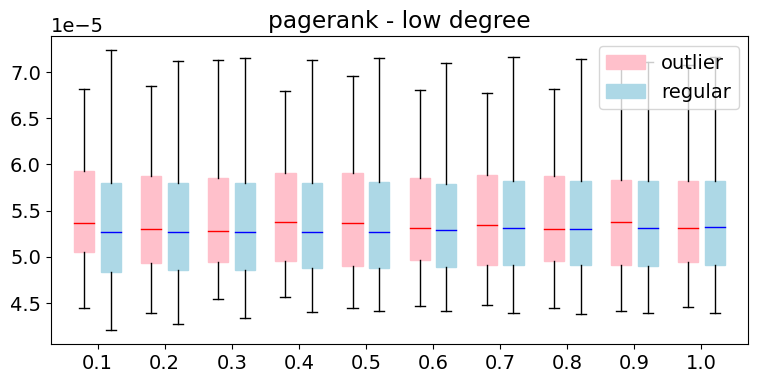

In [34]:
## plot - low degree
fig, ax = plt.subplots(figsize=(9, 4))

for i in np.arange(0,20,2):
    bp = ax.boxplot(A1[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('pagerank - low degree');
#plt.xlabel(r'noise ($\xi$)',fontsize=14)
#fig.savefig('pr_low.pdf');   

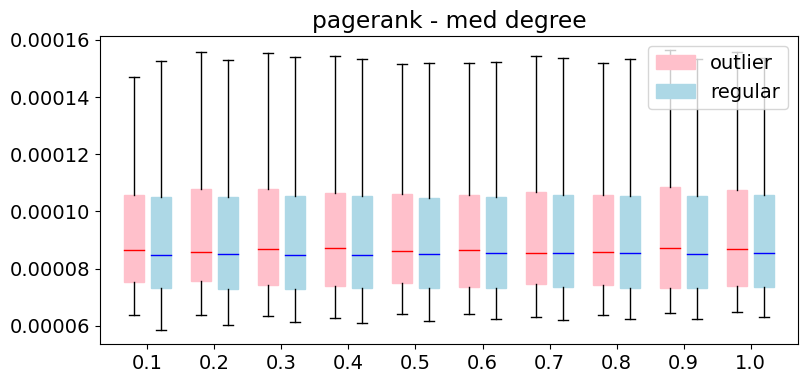

In [35]:
## plot - med degree
fig, ax = plt.subplots(figsize=(9, 4))

for i in np.arange(0,20,2):
    bp = ax.boxplot(A2[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('pagerank - med degree');
#plt.xlabel(r'noise ($\xi$)',fontsize=14)
#fig.savefig('pr_med.pdf');   

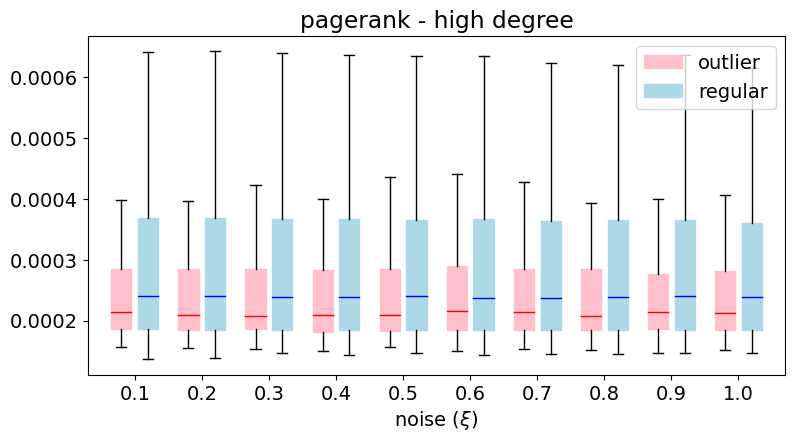

In [36]:
## plot - hi degree
fig, ax = plt.subplots(figsize=(9, 4.4))

for i in np.arange(0,20,2):
    bp = ax.boxplot(A3[i:(i+2)],positions=np.array([(i//2)-.2,(i//2)+0.2]),
                    widths=0.30, showfliers=False, patch_artist=True);
    # fill with colors
    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    colors = ['red', 'blue']
    for patch, color in zip(bp['medians'], colors):
        patch.set_color(color)

plt.xticks(np.arange(0,10), [str(i/10) for i in np.arange(1,11)])
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['outlier', 'regular'], loc='upper right')
plt.title('pagerank - high degree');
plt.xlabel(r'noise ($\xi$)',fontsize=14);
#fig.savefig('pr_hi.pdf');   

## Features with Football graph

Figure 13

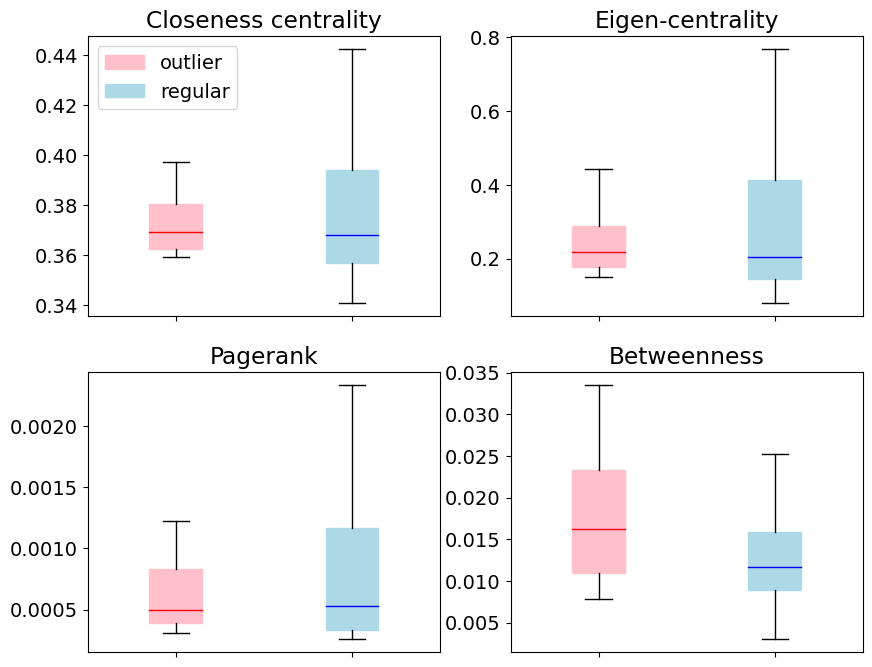

Football graph xi = 0.3572593800978793


In [37]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# e-centrality
cfg.vs['cc'] = g.closeness()
A1 = [v['cc'] for v in cfg.vs if v['anomaly']==True]
A2 = [v['cc'] for v in cfg.vs if v['anomaly']==False]
bp1 = ax1.boxplot([A1,A2],labels=['',''], showfliers=False, patch_artist=True, widths=0.3) 
ax1.set_title("Closeness centrality")

ax1.legend([bp1["boxes"][0], bp1["boxes"][1]], ['outlier', 'regular'], loc='upper right')


# c-centrality
cfg.vs['cc'] = g.eigenvector_centrality()
A1 = [v['cc'] for v in cfg.vs if v['anomaly']==True]
A2 = [v['cc'] for v in cfg.vs if v['anomaly']==False]
bp2 = ax2.boxplot([A1,A2],labels=['',''], showfliers=False, patch_artist=True, widths=0.3) 
ax2.set_title("Eigen-centrality")

# pr
cfg.vs['cc'] = g.pagerank()
A1 = [v['cc'] for v in cfg.vs if v['anomaly']==True]
A2 = [v['cc'] for v in cfg.vs if v['anomaly']==False]
bp3 = ax3.boxplot([A1,A2],labels=['',''], showfliers=False, patch_artist=True, widths=0.3) 
ax3.set_title("Pagerank")

# bet-centrality
## add feature here
n = cfg.vcount()
den = (n-1)*(n-2)/2
cfg.vs['cc'] = [i/den for i in cfg.betweenness()]
A1 = [v['cc'] for v in cfg.vs if v['anomaly']==True]
A2 = [v['cc'] for v in cfg.vs if v['anomaly']==False]
bp4 = ax4.boxplot([A1,A2],labels=['',''], showfliers=False, patch_artist=True, widths=0.3) 
ax4.set_title("Betweenness")


# fill with colors
colors = ['pink', 'lightblue']
for bplot in (bp1, bp2, bp3, bp4):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_color(color)
colors = ['red', 'blue']
for bplot in (bp1, bp2, bp3, bp4):
    for patch, color in zip(bplot['medians'], colors):
        patch.set_color(color)

ax1.legend([bp1["boxes"][0], bp1["boxes"][1]], ['outlier', 'regular'], loc='upper left')

plt.show()
#fig.savefig('football_features.pdf');   

xi = 0
for e in cfg.es:
    xi += int(cfg.vs[e.tuple[0]]['community'] == cfg.vs[e.tuple[1]]['community'])
print('Football graph xi =',1-(xi / cfg.ecount()));


# Example: Email_EU example

As an illustration using a real world graph, we consider the Email-Eu graph built from email data from a European institution. An edge represents an email from some user $x$ to another user $y$. The usernamers are all replaced with numbers. The data is taken from https://snap.stanford.edu/data/index.html.

The data also has some "ground-truth" communities corresponding to 42 departments. Note however that most communities are "weak" in the sense that there are more edges coming out of the community than within the community. Some communities are also very small: 16 communities have less than 10 nodes, and there are even some communities of size 1.

We treat the graph as undirected and keep only the 2-core, which yields 934 nodes and 25500 edges, with 580 nodes of degree 25 or more.
The modularity of the ground-truth communities (departments) is only q(GT) = 0.315.

Clustering this graph with ECG yielded a smaller number of communities (33), many of which have size less than 10,
but the communities are generally more dense, and modularity is q(ECG) = 0.430, higher than with the ground-truth.

We consider two of the measures we introduced earlier to find outliers, namely the ECG coefficient, and the difference in edge distribution.

In Table 1, we plot some statistics for the nodes with degree 25+ having small scores w.r.t. both measures, while in Table 2, we do the same for nodes with high scores. For each node, we look at:
* the proportion of edges in its own ECG community
* the proportion of edges in its own ground-truth community
* the number of ground-truth communities in the neighbourhood

For the first group of nodes, we clearly see that a minority of edges are internal to its ECG community, even more so if we look at the ground-truth communities. We also see that those nodes have neighbours is several different departments (ground-truth communities).
The conclusions are exactly the opposite for the second group of nodes, as expected.



In [38]:
## read data, communities; keep 2-core
g_eu = ig.Graph.Read_Ncol(datadir+'EmailEU/email-Eu-core.txt',directed=False)
c = np.loadtxt(datadir+'EmailEU/email-Eu-core-department-labels.txt',dtype='uint16',usecols=(1))
g_eu.vs['community'] = [c[int(x['name'])] for x in g_eu.vs]
g_eu.vs['core'] = g_eu.coreness()
g_eu.delete_vertices([v for v in g_eu.vs if v['core']<2])
print(g_eu.vcount(),g_eu.ecount())
print('nodes with degree 25+:',sum([x>=25 for x in g_eu.degree()]))
print(Counter(g_eu.vs['community']))
g_eu.vs['deg'] = g_eu.degree()
print('q =',g_eu.modularity(g_eu.vs['community']))

934 25500
nodes with degree 25+: 580
Counter({4: 102, 14: 88, 1: 59, 15: 53, 21: 49, 7: 47, 0: 46, 10: 37, 17: 34, 11: 28, 19: 28, 9: 27, 13: 26, 23: 25, 22: 24, 16: 24, 6: 24, 36: 22, 8: 19, 5: 17, 37: 15, 20: 13, 38: 13, 35: 13, 3: 12, 34: 11, 26: 9, 27: 9, 2: 8, 32: 8, 28: 7, 25: 6, 31: 6, 29: 5, 24: 5, 40: 4, 39: 3, 12: 3, 30: 2, 41: 1, 18: 1, 33: 1})
q = 0.31506543021914657


### Clustering with ECG, votes.

In [39]:
## slightly lower q but higher AMI with ECG
ec = g_eu.community_ecg(ens_size=32)
g_eu.vs['ecg'] = ec.membership
g_eu.es['W'] = ec.W
for v in g_eu.vs:
    v['votes'] = np.mean([g_eu.es[e]['W'] for e in g_eu.incident(v)])
print('q(ECG):',g_eu.modularity(g_eu.vs['ecg']),'AMI',AMI(g_eu.vs['ecg'],g_eu.vs['community']))
g_eu.vs['cluster'] = g_eu.vs['ecg'] 
print(len(Counter(g_eu.vs['ecg'])))

q(ECG): 0.43270878354479053 AMI 0.6123812915031189
33


### Differences in edge distribution

In [40]:
## compute differences
volV = np.sum(g_eu.degree())
volA = np.zeros(max(g_eu.vs['cluster'])+1, dtype='int')
for v in g_eu.vs:
    volA[v['cluster']] += v.degree()

for v in g_eu.vs:
    nei = [g_eu.vs[w]['cluster']==v['cluster'] for w in g_eu.neighbors(v)]
    v['frac'] = np.sum(nei) / len(nei)
    v['exp_frac'] = (volA[v['cluster']] - v.degree()) / (volV - v.degree())
    v['diff'] = v['frac'] - v['exp_frac']

### Participation Coefficient

In [41]:
## participation coef
for v in g_eu.vs:
    l = list(Counter([g_eu.vs[x]['cluster'] for x in g_eu.neighbors(v)]).values())
    s = sum(l)
    v['pc'] = 1-sum([i**2/s**2 for i in l])
    

### Compare varions measures

correlation: -0.9335768288119656


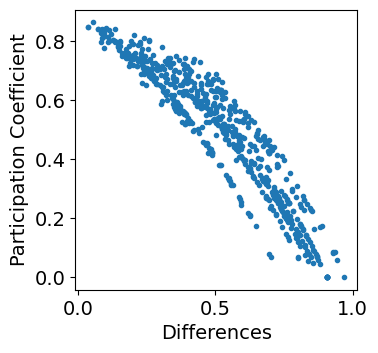

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(221)
X = [v['diff'] for v in g_eu.vs if v['deg']>=20]
Y = [v['pc'] for v in g_eu.vs if v['deg']>=20]
plt.plot(X,Y, '.')
plt.xlabel('Differences')
plt.ylabel('Participation Coefficient')
#plt.title('ECG communities')
print('correlation:',np.corrcoef(X,Y)[0,1])


correlation: -0.9241610347620101


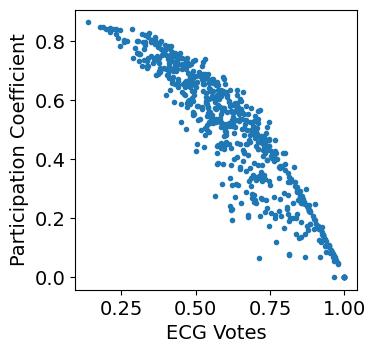

In [43]:
plt.figure(figsize=(8,8))
plt.subplot(221)
X = [v['votes'] for v in g_eu.vs if v['deg']>=20]
Y = [v['pc'] for v in g_eu.vs if v['deg']>=20]
plt.plot(X,Y, '.')
plt.xlabel('ECG Votes')
plt.ylabel('Participation Coefficient')
#plt.title('ECG communities')
print('correlation:',np.corrcoef(X,Y)[0,1])

correlation: 0.9434342626280452


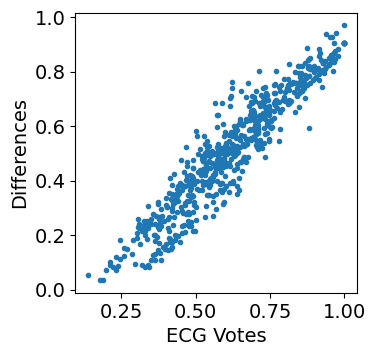

In [44]:
plt.figure(figsize=(8,8))
plt.subplot(221)
X = [v['votes'] for v in g_eu.vs if v['deg']>=20]
Y = [v['diff'] for v in g_eu.vs if v['deg']>=20]
plt.plot(X,Y, '.')
plt.xlabel('ECG Votes')
plt.ylabel('Differences')
#plt.title('ECG communities')
print('correlation:',np.corrcoef(X,Y)[0,1])

### EDA for nodes with low difference and low ECG scores


In [45]:
V = [v['name'] for v in g_eu.vs if v['deg']>=25 and v['diff']<.1 and v['votes']<.25]

## neighbours are in several communities
## small number are in own cluster
L = []
for s in V:
    v = g_eu.vs.find(s)
    oc = v['cluster']
    d = v['deg']
    ctr = Counter([g_eu.vs[i]['cluster'] for i in g_eu.neighbors(v)])
    prop_ecg = ctr[oc] / d
    
    gt = v['community']
    ctr = Counter([g_eu.vs[i]['community'] for i in g_eu.neighbors(v)])
    prop_gt = ctr[gt] / d
    n = g_eu.vcount()
    den = (n-1)*(n-2)/2
    L.append([prop_ecg,prop_gt,len(ctr),g_eu.betweenness(s)/den,g_eu.pagerank(s)])
    
D = pd.DataFrame(L, columns=['prop. of edges in own ECG community',
                         'prop. of edges in own GT community',
                         'number of GT community touched',
                            'bet','pr'])
df = D.round(decimals=3)
df

,prop. of edges in own ECG community,prop. of edges in own GT community,number of GT community touched,bet,pr
0,0.223,0.052,34,0.020,0.004
1,0.124,0.076,31,0.040,0.006
2,0.291,0.037,36,0.092,0.009
3,0.245,0.222,31,0.015,0.005
4,0.079,0.059,29,0.012,0.003
5,0.217,0.137,26,0.006,0.003
6,0.163,0.038,29,0.016,0.004
7,0.167,0.056,27,0.001,0.001


### EDA for nodes with high difference and high ECG scores


In [46]:
V = [v['name'] for v in g_eu.vs if v['deg']>=25 and v['diff']>.9 and v['votes']>.9]

## neighbours are in several communities
## small number are in own cluster
L = []
for s in V:
    v = g_eu.vs.find(s)
    oc = v['cluster']
    d = v['deg']
    ctr = Counter([g_eu.vs[i]['cluster'] for i in g_eu.neighbors(v)])
    prop_ecg = ctr[oc] / d
    
    gt = v['community']
    ctr = Counter([g_eu.vs[i]['community'] for i in g_eu.neighbors(v)])
    prop_gt = ctr[gt] / d
    n = g_eu.vcount()
    den = (n-1)*(n-2)/2
    L.append([prop_ecg,prop_gt,len(ctr),g_eu.betweenness(s)/den,g_eu.pagerank(s)])
    
D = pd.DataFrame(L, columns=['prop. of edges in own ECG community',
                         'prop. of edges in own GT community',
                         'number of GT community touched',
                            'bet','pr'])
df = D.round(decimals=3)
df

,prop. of edges in own ECG community,prop. of edges in own GT community,number of GT community touched,bet,pr
0,1.00,0.983,2,0.0,0.001
1,1.00,1.000,1,0.0,0.001
2,0.97,0.970,2,0.0,0.001
3,1.00,0.981,2,0.0,0.001
4,1.00,1.000,1,0.0,0.001
5,1.00,0.967,2,0.0,0.001
6,1.00,0.969,2,0.0,0.001
7,1.00,1.000,1,0.0,0.001
8,1.00,0.949,2,0.0,0.001


# EXTRA -- Experiments with new "critical beta" measure

### some 'stories'